## DBSCAN
This implementation and notebook is inspired from the original DBSCAN algorithm and article as given in 
[DBSCAN Wikipedia](https://en.wikipedia.org/wiki/DBSCAN).

Stands for __Density-based spatial clustering of applications with noise__ . 

DBSCAN is clustering algorithm that tries to captures the intuition that if two points belong to the same cluster they should be close to one another. It does so by finding regions that are densely packed together, i.e, the points that have many close neighbours.


### When to use ?

1. You need a robust clustering algorithm.
2. You don't know how many clusters there are in the dataset
3. You find it difficult to guess the number of clusters there are just by eyeballing the dataset.
4. The clusters are of arbitrary shapes.
5. You want to detect outliers/noise.

### Why DBSCAN ? 

This algorithm is way better than other clustering algorithms such as [k-means](https://en.wikipedia.org/wiki/K-means_clustering) whose only job is to find circular blobs. It is smart enough to figure out the number of clusters in the dataset on its own, unlike k-means where you need to specify 'k'.  It can also find clusters of arbitrary shapes, not just circular blobs.  Its too robust to be affected by outliers (the noise points) and isn't fooled by them, unlike k-means where the entire centroid get pulled thanks to pesky outliers. Plus, you can fine-tune its parameters depending on what you are clustering.

#### Have a look at these [neat animations](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/) of DBSCAN to see for yourself.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## First lets grab a dataset
We will take the moons dataset which is pretty good at showing the power of DBSCAN. 

Lets generate 200 random points in the shape of two moons

In [2]:
from sklearn.datasets import make_moons

x, label = make_moons(n_samples=200, noise=0.1, random_state=19)

## Visualize the dataset using matplotlib
You will observe that the points are in the shape of two crescent moons. 

The challenge here is to cluster the two moons. 

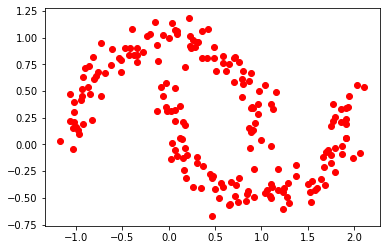

In [3]:
plt.plot(x[:,0], x[:,1],'ro')

### Abstract of the Algorithm
The DBSCAN algorithm can be abstracted into the following steps:

- Find the points in the $ε$ (eps) neighborhood of every point, and identify the core points with more than <b>min_pts</b> neighbors.
- Find the connected components of core points on the neighbor graph, ignoring all non-core points.
- Assign each non-core point to a nearby cluster if the cluster is an $ε$ (eps) neighbor, otherwise assign it to noise.


## Preparing the points
Initially we label all the points in the dataset as __undefined__ .

__points__ is our database of all points in the dataset.

In [4]:
points = { (point[0],point[1]):{'label':'undefined'} for point in x }

# Helper functions

In [5]:
def euclidean_distance(q, p):
    """
        Calculates the Euclidean distance
        between points P and Q
    """
    a = pow((q[0] - p[0]), 2)
    b = pow((q[1] - p[1]), 2)
    return pow((a + b), 0.5)

In [6]:
def find_neighbors(db, q, eps):
    """
        Finds all points in the DB that
        are within a distance of eps from Q
    """
    return [p for p in db if euclidean_distance(q, p) <= eps]

In [7]:
def plot_cluster(db, clusters):
    """
        Extracts all the points in the DB and puts them together
        as seperate clusters and finally plots them
    """
    temp = []
    noise = []
    for i in clusters:
        stack = []
        for k, v in db.items():
            if v["label"] == i:
                stack.append(k)
            elif v["label"] == "noise":
                noise.append(k)
        temp.append(stack)

    color = iter(plt.cm.rainbow(np.linspace(0, 1, len(clusters))))
    for i in range(0, len(temp)):
        c = next(color)
        x = [l[0] for l in temp[i]]
        y = [l[1] for l in temp[i]]
        plt.plot(x, y, "ro", c=c)

    x = [l[0] for l in noise]
    y = [l[1] for l in noise]
    plt.plot(x, y, "ro", c="0")

# Implementation of DBSCAN

Initialize an empty list, clusters = $[ ]$ and cluster identifier, c = 0

1. For each point  p in our database/dict  db :

    1.1 Check if p is already labelled. If it's already labelled (means it already been associated to a cluster), continue to the next point,i.e, go to step 1
    
    1.2. Find the list of neighbors of p , i.e, points that are within a distance of eps from p
    
    1.3. If p does not have atleast min_pts neighbours, we label it as noise and go back to step 1
    
    1.4. Initialize the cluster, by incrementing c by 1
    
    1.5. Append the cluster identifier c to clusters
    
    1.6. Label p with the cluster identifier c
    
    1.7 Remove p from the list of neighbors (p will be detected as its own neighbor because it is within eps of itself)
    
    1.8. Initialize the seed_set as a copy of neighbors
   
    1.9. While the seed_set is not empty:
        1.9.1. Removing the 1st point from seed_set and initialise it as q
        1.9.2. If it's label is noise, label it with c
        1.9.3. If it's not unlabelled, go back to step 1.9
        1.9.4. Label q with c
        1.9.5. Find the neighbours of q 
        1.9.6. If there are atleast min_pts neighbors, append them to the seed_set

In [8]:
def dbscan(db,eps,min_pts):
    '''
        Implementation of the DBSCAN algorithm
    '''
    clusters = []
    c = 0
    for p in db:
        if db[p]["label"] != "undefined":
            continue
        neighbors = find_neighbors(db, p, eps)
        if len(neighbors) < min_pts:
            db[p]["label"] = "noise"
            continue
        c += 1
        clusters.append(c)
        db[p]["label"] = c
        neighbors.remove(p)
        seed_set = neighbors.copy()
        while seed_set != []:
            q = seed_set.pop(0)
            if db[q]["label"] == "noise":
                db[q]["label"] = c
            if db[q]["label"] != "undefined":
                continue
            db[q]["label"] = c
            neighbors_n = find_neighbors(db, q, eps)
            if len(neighbors_n) >= min_pts:
                seed_set = seed_set + neighbors_n
    return db, clusters


## Lets run it!

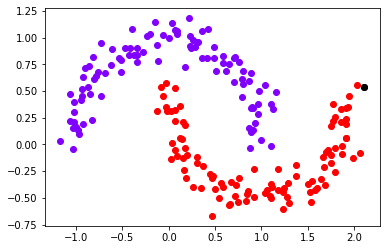

In [9]:
eps = 0.25
min_pts = 12

db,clusters = dbscan(points,eps,min_pts)

plot_cluster(db,clusters)

I encourage you to try with different datasets and playing with the values of eps and min_pts.

Also, try kmeans on this dataset and see how it compares to dbscan. 

I hope by now you are convinced about about how cool dbscan is. But it has its pitfalls.
### When NOT to use ?

1. You have a high dimentional dataset. Euclidean distance will fail thanks to '[curse of dimentionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Distance_functions)'.
2. We have used a dict to store the points. So we can't do anything about the order in which the points will be processed. So it's not entirely deterministic.
3. Won't work well if there are large differences in density. Finding the min_pts and $ε$ combination will be difficult.
4. Choosing the $ε$ without understanding the data and its scale, might result is poor clustering performance.